# Connected and Autonomous Driving - Control module

----

In this module, we will learn how to control an autonomous vehicle to follow a specific path defined by a serie of waypoints. Our goal is to emulate the input command that would normally be provided by a human user: torque, brake and steering.

In this notebook, you will get to implement the PID controller covered in class, then use your code directly inside the CARLA Simulation.

In [3]:
#Import libraries
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.widgets import Slider

## Longitudinal controller

Before handling directions, let's start by making our car follow a target speed by going in a straigth line.

### Let's start with a simple P controller

The Proportional (P) controller try to reduce the difference between the target speed and the current speed: $error(t) = v(t) - v_{target}$.

To do so, it provide a throttle value that is proportional to that error, with a factor called proportional gain $K_p$:

$$throttle = K_p * error(t)$$

Fill the code below in update() to calculate the error value as well as the output throttle


In [4]:
 
# Define PID Controller class with resistance
class ProportionalControllerWithResistance:
    def __init__(self, Kp, target_speed=0, resistance_factor=0.1):
        self.Kp = Kp
        self.target_speed = target_speed
        self.resistance_factor = resistance_factor  # Resistance to throttle (e.g., air resistance, friction)
 
    def update(self, current_value, dt):
        ##TODO##
        error = self.target_speed - current_value
        output = self.Kp * error
        ##TODO##
        return output - self.resistance_factor * current_value  # Reduce output by a resistance factor
    
    def set_target(self, target):
        self.target_speed = target
 


Now, let's do a simple simulation over 50 seconds to see how your controller behave
- Does it reach the target speed ?
- What happens when you change $K_p$ ? The resistance ?

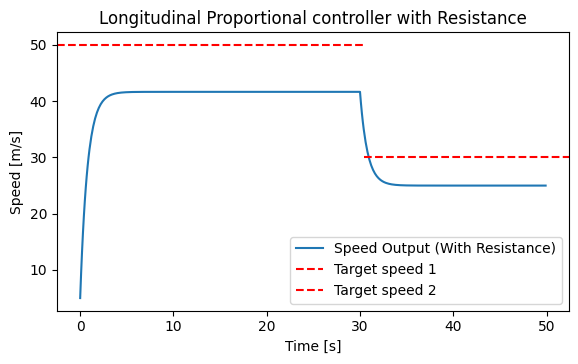

In [16]:
# Simulation parameters
dt = 0.1  # Time step
time = np.arange(0, 50, dt)  # Simulation time
target_speed1 = 50  # Target speeds
target_speed2 = 30
switch_t = 30  # Time to change vehicle target speed
 
# Initialize the PID controller with disturbance (resistance)
pid_with_resistance = ProportionalControllerWithResistance(Kp=1, target_speed=target_speed1, resistance_factor=0.2)
 
# Initial conditions
speed = 0
throttle_with_resistance = []
speed_record_with_resistance = []
 
# Simulate the system with resistance
for t in time:
    control = pid_with_resistance.update(speed, dt)
    speed += control * dt  # Speed is affected by throttle control and resistance
    throttle_with_resistance.append(control)
    speed_record_with_resistance.append(speed)
    if t==switch_t:
        pid_with_resistance.set_target(target_speed2)
 
# Plot setup
fig, ax = plt.subplots()
plt.subplots_adjust(left=0.1, bottom=0.3)
 
l, = plt.plot(time, speed_record_with_resistance, label="Speed Output (With Resistance)")
plt.axhline(target_speed1, color='r', linestyle='--', label='Target speed 1', xmax=switch_t/50)
plt.axhline(target_speed2, color='r', linestyle='--', label='Target speed 2', xmin=switch_t/50)
plt.xlabel('Time [s]')
plt.ylabel('Speed [m/s]')
plt.title('Longitudinal Proportional controller with Resistance')
plt.legend()
plt.show()

### Adding integrals to look at the past

To get closer to the target, we improve our controler as a proportional integral (PI). 

$$throttle(t) = K_p * error(t) + K_i * \sum_{n=0} ^t error(n)\Delta t $$

The additional term accumulate previous errors over time to close the gap with the target.

Include this new version in the update() method.

In [ ]:
class PIControllerWithResistance:
    def __init__(self, Kp, Ki, target_speed=0, resistance_factor=0.1):
        self.Kp = Kp
        self.Ki = Ki
        self.target_speed = target_speed
        self.integral = 0
        self.resistance_factor = resistance_factor  # Resistance to throttle (e.g., air resistance, friction)
 
    def update(self, current_value, dt):
        ##TODO##
        error = self.target_speed - current_value
        self.integral += error * dt
        output = self.Kp * error + self.Ki * self.integral
        ##TODO##
        return output - self.resistance_factor * current_value  # Reduce output by a resistance factor
    
    def set_target(self, target):
        self.target_speed = target
 

Let's simulate again.

- Is it reaching the target better than before ?
- Why did the integral component improve the controller ?
- What new issue did the PI introduce ?
- what happens when you change $K_p$ and $K_i$ ?

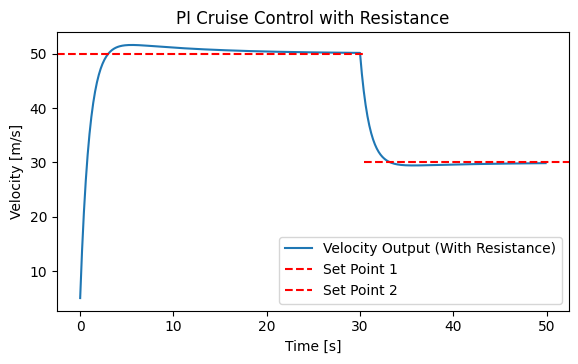

In [ ]:
# Simulation parameters
dt = 0.1  # Time step
time = np.arange(0, 50, dt)  # Simulation time
target_speed1 = 50  # Target speeds
target_speed2 = 30
switch_t = 30  # Time to change vehicle target speed
 
# Initialize the PID controller with disturbance (resistance)
pid_with_resistance = PIControllerWithResistance(Kp=1.0, Ki=0.1, target_speed=target_speed1, resistance_factor=0.05)
 
# Initial conditions
speed = 0
throttle_with_resistance = []
speed_record_with_resistance = []
 
# Simulate the system with resistance
for t in time:
    control = pid_with_resistance.update(speed, dt)
    speed += control * dt  # Speed is affected by throttle control and resistance
    throttle_with_resistance.append(control)
    speed_record_with_resistance.append(speed)
    if t==switch_t:
        pid_with_resistance.set_target(target_speed2)
 
# Plot setup
fig, ax = plt.subplots()
plt.subplots_adjust(left=0.1, bottom=0.3)
 
l, = plt.plot(time, speed_record_with_resistance, label="Velocity Output (With Resistance)")
plt.axhline(target_speed1, color='r', linestyle='--', label='Set Point 1', xmax=switch_t/50)
plt.axhline(target_speed2, color='r', linestyle='--', label='Set Point 2', xmin=switch_t/50)
plt.xlabel('Time [s]')
plt.ylabel('Velocity [m/s]')
plt.title('PI Cruise Control with Resistance')
plt.legend()
plt.show()

### Finishing the PID

Finally, the Proportional Integral Derivative (PID) controller adds a term to consider future error:

$$throttle(t) = K_p * error(t) + K_i * \sum_{n=0} ^t error(n)\Delta t + K_d * \frac{error(t)-error(t-1)}{\Delta t} $$

In [ ]:
class PIDControllerWithResistance:
    def __init__(self, Kp, Ki, Kd, target_speed=0, resistance_factor=0.1):
        self.Kp = Kp
        self.Ki = Ki
        self.Kd = Kd
        self.target_speed = target_speed
        self.prev_error = 0
        self.integral = 0
        self.resistance_factor = resistance_factor  # Resistance to throttle (e.g., air resistance, friction)
 
    def update(self, current_value, dt):
        ##TODO##
        error = self.target_speed - current_value
        self.integral += error * dt
        derivative = (error - self.prev_error) / dt
        output = self.Kp * error + self.Ki * self.integral + self.Kd * derivative
        self.prev_error = error
        ##TODO##
        return output - self.resistance_factor * current_value  # Reduce output by a resistance factor
    
    def set_target(self, target):
        self.target_speed = target
 

Let s simulate again

- Is it reaching the target better than before ?
- Why did the derivative component improve the controller ? 
- what happens when you change $K_p$, $K_i$ and $K_d$ ?

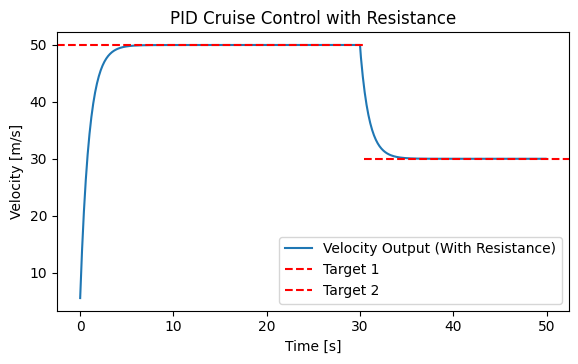

In [ ]:
# Simulation parameters
dt = 0.1  # Time step
time = np.arange(0, 50, dt)  # Simulation time
target_speed1 = 50  # Target speeds
target_speed2 = 30
switch_t = 30  # Time to change vehicle target speed

# Initialize the PID controller with disturbance (resistance)
pid_with_resistance = PIDControllerWithResistance(Kp=1.0, Ki=0.05, Kd=0.01, target_speed=target_speed1, resistance_factor=0.05)
 
# Initial conditions
speed = 0
throttle_with_resistance = []
speed_record_with_resistance = []
 
# Simulate the system with resistance
for t in time:
    control = pid_with_resistance.update(speed, dt)
    speed += control * dt  # Speed is affected by throttle control and resistance
    throttle_with_resistance.append(control)
    speed_record_with_resistance.append(speed)
    if t==switch_t:
        pid_with_resistance.set_target(target_speed2)

 
# Plot setup
fig, ax = plt.subplots()
plt.subplots_adjust(left=0.1, bottom=0.3)
 
l, = plt.plot(time, speed_record_with_resistance, label="Velocity Output (With Resistance)")
plt.axhline(target_speed1, color='r', linestyle='--', label='Target 1', xmax=switch_t/50)
plt.axhline(target_speed2, color='r', linestyle='--', label='Target 2', xmin=switch_t/50)
plt.xlabel('Time [s]')
plt.ylabel('Velocity [m/s]')
plt.title('PID Cruise Control with Resistance')
plt.legend()
plt.show()

You have now successfully built a longitudinal PID controll. Now, we will add a lateral PID controll as well in order to control the direction of our vehicle.
For this part, we will move to the "control.py" file to finalize the PID controller. 

When you are done with your control.py file, you can test it by running the Simulation_Control.py script to see your car drive around the CARLA simulation.